In [1]:
!pip install pyxdf

In [22]:
# Ensure interactive features in matplotlib
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets, HBox, VBox
import pandas as pd
import pyxdf
from datetime import datetime
import csActions

In [3]:
import matplotlib.pyplot as plt

class DraggableVLine:
    """
    A class to manage a vertical line on a Matplotlib plot that can be dragged along the x-axis.

    This class provides interactivity for vertical lines in Matplotlib, allowing users to click 
    and drag the line along the x-axis. When the line is dragged, an optional callback function 
    can be triggered to handle updates or additional processing related to the new line position.

    Attributes:
    -----------
    line : matplotlib.lines.Line2D
        The vertical line to be made draggable.
    press : float or None
        Stores the x-coordinate where the mouse was pressed, used to determine the start of dragging.
    on_drag_callback : function or None
        A function to be called when the line drag ends, with the new x-coordinate passed as an argument.
    
    Methods:
    --------
    connect():
        Connects the event listeners for mouse press, motion, and release.
    on_press(event):
        Handles the mouse press event. Records the x-coordinate if the event occurs on the line.
    on_motion(event):
        Handles the mouse motion event. Updates the line's position as the mouse is dragged.
    on_release(event):
        Handles the mouse release event. Finalizes the drag and triggers the callback if provided.
    """
    
    def __init__(self, line, on_drag_callback=None):
        """
        Initializes a DraggableVLine instance.

        Parameters:
        -----------
        line : matplotlib.lines.Line2D
            The vertical line to be made draggable.
        on_drag_callback : function, optional
            A callback function that takes the new x-coordinate of the line as input.
        """
        self.line = line  # Reference to the matplotlib line object.
        self.press = None  # Variable to track whether the line is being dragged.
        self.on_drag_callback = on_drag_callback  # Optional callback function after drag.
        self.connect()  # Connect the event listeners to the line.

    def connect(self):
        """
        Connects the mouse event listeners (press, release, motion) to the line.

        This method establishes connections between the mouse events and the corresponding event handlers.
        The handlers are called whenever the user interacts with the plot.

        Events:
        -------
        - button_press_event: Triggers when the mouse is pressed down.
        - button_release_event: Triggers when the mouse button is released.
        - motion_notify_event: Triggers when the mouse is moved.
        """
        self.cidpress = self.line.figure.canvas.mpl_connect('button_press_event', self.on_press)
        self.cidrelease = self.line.figure.canvas.mpl_connect('button_release_event', self.on_release)
        self.cidmotion = self.line.figure.canvas.mpl_connect('motion_notify_event', self.on_motion)

    def on_press(self, event):
        """
        Handles the mouse press event.

        Checks if the mouse press occurred on the draggable line. If so, records the x-coordinate
        where the press occurred. If the press is outside the line's axes, or the press does not
        occur on the line, nothing happens.

        Parameters:
        -----------
        event : matplotlib.backend_bases.MouseEvent
            The mouse event containing information about the mouse click.
        """
        if event.inaxes != self.line.axes:  # Ensure the press is within the plot axes.
            return
        contains, _ = self.line.contains(event)  # Check if the press occurred on the line.
        if not contains:
            return
        self.press = event.xdata  # Store the x-coordinate where the press happened.

    def on_motion(self, event):
        """
        Handles the mouse motion event.

        Updates the line's position as the mouse is dragged, redrawing the plot with the new line position.
        This only occurs if a press event has been registered (i.e., the line is currently being dragged),
        and if the motion occurs within the plot's axes.

        Parameters:
        -----------
        event : matplotlib.backend_bases.MouseEvent
            The mouse event containing information about the mouse movement.
        """
        if self.press is None or event.inaxes != self.line.axes:  # Only drag if a press occurred.
            return
        self.line.set_xdata(event.xdata)  # Update the line's x-coordinate to follow the mouse.
        self.line.figure.canvas.draw_idle()  # Redraw the canvas without blocking.

    def on_release(self, event):
        """
        Handles the mouse release event.

        Finalizes the drag action, resetting the press state and calling the optional callback function,
        if provided, with the new x-coordinate of the line.

        Parameters:
        -----------
        event : matplotlib.backend_bases.MouseEvent
            The mouse event containing information about the mouse release.
        """
        self.press = None  # Reset the press state, ending the drag.
        if self.on_drag_callback:
            self.on_drag_callback(event.xdata)  # Trigger the callback with the final x-coordinate.
        self.line.figure.canvas.draw_idle()  # Redraw the canvas to finalize the new position.


In [4]:
class LineHandler:
    """
    Class to handle adding, dragging, and removing vertical lines on a plot,
    and manage interactive modes such as zoom, region selection, and finding maximums.

    Attributes:
        fig (matplotlib.figure.Figure): The matplotlib figure object.
        ax (matplotlib.axes.Axes): The axes of the plot.
        x (np.ndarray): The x data of the plot.
        y (np.ndarray): The y data of the plot.
        draggable_lines (list of DraggableVLine): List of draggable vertical lines on the plot.
        mode (str): The current interaction mode (e.g., 'drag', 'add', 'find').
        press (float or None): x-coordinate of the mouse press for region selection.
        shaded_area (matplotlib.patches.Polygon or None): Shaded region for actions like zoom or max-finding.
    """
    def __init__(self, fig, ax, x, y):
        """
        Initialize the LineHandler with a figure, axes, and data.

        Args:
            fig (matplotlib.figure.Figure): The figure object.
            ax (matplotlib.axes.Axes): The axes object.
            x (np.ndarray): The x-axis data.
            y (np.ndarray): The y-axis data.
        """
        self.fig = fig  # Store the figure object.
        self.ax = ax  # Store the axes object.
        self.x = x  # Store x data.
        self.y = y  # Store y data.
        self.draggable_lines = []  # List to store all draggable lines.
        self.mode = 'drag'  # Default mode for interaction.
        self.press = None  # To track the press state (for region selection).
        self.shaded_area = None  # To store the shaded area for selection actions.
        self.connect_events()

    def add_line(self, xdata, color='b', alpha=0.3):
        """
        Add a vertical line to the plot and make it draggable.

        Args:
            xdata (float): x-coordinate where the vertical line is added.
            color (str, optional): Color of the line. Defaults to 'b'.
            alpha (float, optional): Transparency level of the line. Defaults to 0.3.
        """
        line = self.ax.axvline(x=xdata, color=color, linestyle='-', alpha=alpha)  # Create vertical line.
        draggable_line = DraggableVLine(line)  # Make the line draggable.
        self.draggable_lines.append(draggable_line)  # Store in the list.
        self.fig.canvas.draw_idle()  # Redraw the canvas.
        

    def connect_events(self):
        """
        Connect the figure canvas events to the respective handler functions for mouse interactions.
        """
        self.cidpress = self.fig.canvas.mpl_connect('button_press_event', self.on_click)
        self.cidrelease = self.fig.canvas.mpl_connect('button_release_event', self.on_release)
        self.cidmotion = self.fig.canvas.mpl_connect('motion_notify_event', self.on_motion)

    def update_mode(self, change):
        """
        Update the interaction mode based on user input (e.g., radio button).

        Args:
            change (dict): Dictionary containing information about the mode change.
        """
        self.mode = change['new']  # Set mode to the new value.

    def on_click(self, event):
        """
        Handle mouse click events based on the current interaction mode.

        Args:
            event (matplotlib.backend_bases.Event): The mouse click event.
        """
        if self.mode == 'add':
            self.add_line(event.xdata, color='red')  # Add a red line at the clicked position.

        elif self.mode == 'drag':
            # Enable dragging for all lines.
            for line in self.draggable_lines:
                line.on_press(event)

        elif self.mode in ['find', 'zoom in', 'remove']:
            self.press = event.xdata  # Store starting x-coordinate for region selection.
            if self.shaded_area:
                self.shaded_area.remove()  # Remove previous shaded area, if any.
            # Create a new shaded area depending on mode.
            color = 'green' if self.mode == 'find' else ('blue' if self.mode == 'zoom in' else 'red')
            self.shaded_area = self.ax.axvspan(self.press, self.press, color=color, alpha=0.3)

    def on_motion(self, event):
        """
        Handle mouse motion events for region selection (zoom, find, or remove).

        Args:
            event (matplotlib.backend_bases.Event): The mouse motion event.
        """
        if self.press is None or self.mode not in ['find', 'zoom in', 'remove']:
            return  # Do nothing if no region is being selected.

        # Update shaded region as the mouse moves.
        self.shaded_area.set_xy([[self.press, 0], [self.press, 1], [event.xdata, 1], [event.xdata, 0]])
        self.fig.canvas.draw_idle()  # Redraw the canvas.

    def on_release(self, event):
        """
        Handle mouse release events and process actions like zoom, finding max, or removing lines.

        Args:
            event (matplotlib.backend_bases.Event): The mouse release event.
        """
        if self.mode == 'drag':
            for line in self.draggable_lines:
                line.on_release(event)  # Release all draggable lines.

        elif self.mode == 'find' and self.press is not None:
            start_x, end_x = sorted([self.press, event.xdata])  # Get the selected region.
            self._find_max_in_region(start_x, end_x)

        elif self.mode == 'zoom in' and self.press is not None:
            start_x, end_x = sorted([self.press, event.xdata])
            self._zoom_in_region(start_x, end_x)

        elif self.mode == 'remove' and self.press is not None:
            start_x, end_x = sorted([self.press, event.xdata])
            self._remove_lines_in_region(start_x, end_x)

        self.press = None  # Reset press state.
        if self.shaded_area:
            self.shaded_area.remove()  # Remove shaded area.
            self.shaded_area = None
        self.fig.canvas.draw_idle()  # Redraw the canvas.

    def _find_max_in_region(self, start_x, end_x):
        """
        Find the maximum y-value in the selected x-region and add a vertical line at the x-coordinate of the max.

        Args:
            start_x (float): Starting x-coordinate of the region.
            end_x (float): Ending x-coordinate of the region.
        """
        mask = (self.x >= start_x) & (self.x <= end_x)  # Mask for x-values in the selected region.
        if np.any(mask):
            x_in_region = self.x[mask]
            y_in_region = self.y[mask]
            max_x = x_in_region[np.argmax(y_in_region)]  # Find x corresponding to the max y.
            self.add_line(max_x, color='red')  # Add a red line at the maximum point.

    def _zoom_in_region(self, start_x, end_x):
        """
        Zoom into the selected x-region and adjust y-limits to fit the data.

        Args:
            start_x (float): Starting x-coordinate of the zoom region.
            end_x (float): Ending x-coordinate of the zoom region.
        """
        mask = (self.x >= start_x) & (self.x <= end_x)
        if np.any(mask):
            min_y, max_y = np.min(self.y[mask]), np.max(self.y[mask])
            self.update_plot_limits(start_x, end_x, min_y, max_y)

    def _remove_lines_in_region(self, start_x, end_x):
        """
        Remove all draggable lines within the selected x-region.

        Args:
            start_x (float): Starting x-coordinate of the removal region.
            end_x (float): Ending x-coordinate of the removal region.
        """
        to_remove = [line for line in self.draggable_lines if start_x <= line.line.get_xdata()[0] <= end_x]
        for line in to_remove:
            line.line.remove()  # Remove the line from the plot.
            self.draggable_lines.remove(line)  # Remove from the list of draggable lines.

    def update_plot_limits(self, min_x, max_x, min_y, max_y):
        """
        Update the plot limits for zoom or reset.

        Args:
            min_x (float): Minimum x-axis limit.
            max_x (float): Maximum x-axis limit.
            min_y (float): Minimum y-axis limit.
            max_y (float): Maximum y-axis limit.
        """
        self.ax.set_xlim(min_x, max_x)  # Set x-axis limits.
        self.ax.set_ylim(min_y, max_y)  # Set y-axis limits.
        self.fig.canvas.draw_idle()  # Redraw the canvas.


In [5]:
class TimeSeries:
    def __init__(self, x, y, srate=None):
        self.time = pd.Series(x)
        self.level = pd.Series(y)
        if srate is not None:
            self.srate = srate
        else:
            self.srate = round(1.0 / (self.time.diff().mean()))

    def slicetime(self, time_min, time_max):
        mask = (self.time >= time_min) & (self.time <= time_max)
        return TimeSeries(self.time.loc[mask], self.level.loc[mask], self.srate)

    def to_dataframe(self):
        return pd.DataFrame({"time": self.time, "level": self.level, "srate": self.srate})


In [6]:
class SpectHRDataset:
    def __init__(self, filename, ecg_index=1, br_index=None, event_index=None, par=None):
        self.ecg = None
        self.br = None
        self.events = None
        self.loadData(filename, ecg_index, br_index, event_index)
        self.history = []
        self.par = {}
        self.starttime = None

    def loadData(self, filename, ecg_index=None, br_index=None, event_index=None):
        rawdata, header = pyxdf.load_xdf(filename)

        if ecg_index is not None:
            ecg_x = pd.Series(rawdata[ecg_index]["time_stamps"])
            self.starttime = ecg_x[0]
            ecg_y = pd.Series(rawdata[ecg_index]["time_series"].flatten())
            ecg_x = ecg_x - self.starttime
            self.ecg = TimeSeries(ecg_x, ecg_y)
            #self.ecg = self.ecg.slicetime(500,505)
            #self.starttime = self.ecg.time.iloc[0]
            
        if br_index is not None:
            br_x = pd.Series(rawdata[br_index]["time_stamps"])
            br_y = pd.Series(rawdata[br_index]["time_series"].flatten())
            br_x = br_x - self.starttime
            self.br = TimeSeries(br_x, br_y)

        if event_index is not None:
            event_timestamps = pd.Series(rawdata[event_index]["time_stamps"])
            event_labels = rawdata[event_index]["time_series"]
            self.events = pd.DataFrame({'timestamp': event_timestamps - self.starttime, 'label': event_labels})

    def log_action(self, action_name, params):
        log_entry = {
            'action': action_name,
            'timestamp': datetime.now(),
            'parameters': params
        }
        self.history.append(log_entry)


In [15]:
def spectHRplot(data, x_min=None, x_max=None):
    if x_min is None:
        x_min = data.ecg.time.min()
    if x_max is None:
        x_max = data.ecg.time.max()

    if data.br is not None:
        fig, (ax_ecg, ax_br) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    else:
        fig, ax_ecg = plt.subplots(figsize=(12, 6))

    line_handler = LineHandler(fig, ax_ecg, data.ecg.time, data.ecg.level)

    def update_plot():
        time = data.ecg.time
        level = data.ecg.level

        # Mask the time range
        mask = (time >= x_min) & (time <= x_max)
        num_points = mask.sum()

        # Downsample if necessary for better performance
        if num_points > 1000:
            factor = max(1, num_points // 1000)
            time = time[mask][::factor]
            level = level[mask][::factor]
        else:
            time = time[mask]
            level = level[mask]

        ax_ecg.clear()
        ax_ecg.plot(time, level, label='ECG Signal', color='blue')

        # Plot draggable lines for RTopTimes if they exist
        if hasattr(data.ecg, 'RTopTimes'):
            RTopTimes = data.ecg.RTopTimes
            if len(RTopTimes) <= 20:
                for rtop in RTopTimes:
                    if x_min <= rtop <= x_max:
                        line_handler.add_line(rtop, color = 'r')

        ax_ecg.set_title('ECG Signal with Zoom and Move Functionality')
        ax_ecg.set_xlabel('Time (seconds)')
        ax_ecg.set_ylabel('ECG Level')
        ax_ecg.set_xlim(x_min, x_max)
        ax_ecg.grid()

        # If the BR timeseries exists, plot it in the subplot
        if data.br is not None:
            br_time = data.br.time
            br_level = data.br.level
            mask_br = (br_time >= x_min) & (br_time <= x_max)
            num_points_br = mask_br.sum()

            # Downsample BR data if necessary
            if num_points_br > 1000:
                factor_br = max(1, num_points_br // 1000)
                br_time = br_time[mask_br][::factor_br]
                br_level = br_level[mask_br][::factor_br]
            else:
                br_time = br_time[mask_br]
                br_level = br_level[mask_br]

            ax_br.clear()
            ax_br.plot(br_time, br_level, label='Breathing Signal', color='green')
            ax_br.set_ylabel('Breathing Level')
            ax_br.grid()

        fig.canvas.draw_idle()

    update_plot()

    # Functions to zoom, pan, and update both axes
    def zoom_in(b):
        nonlocal x_min, x_max
        x_center = (x_min + x_max) / 2
        x_range = (x_max - x_min) / 2
        x_min = max(0, x_center - x_range / 2)
        x_max = min(data.ecg.time.max(), x_center + x_range / 2)
        update_plot()

    def zoom_out(b):
        nonlocal x_min, x_max
        x_range = (x_max - x_min) * 2
        x_min = max(0, x_min - x_range / 4)
        x_max = min(data.ecg.time.max(), x_max + x_range / 4)
        update_plot()

    def move_left(b):
        nonlocal x_min, x_max
        move_amount = (x_max - x_min) / 4
        x_min = max(0, x_min - move_amount)
        x_max = min(data.ecg.time.max(), x_max - move_amount)
        update_plot()

    def move_right(b):
        nonlocal x_min, x_max
        move_amount = (x_max - x_min) / 4
        x_min = max(0, x_min + move_amount)
        x_max = min(data.ecg.time.max(), x_max + move_amount)
        update_plot()

    # Buttons for zoom and panning controls
    zoom_in_button = widgets.Button(description="Zoom In")
    zoom_out_button = widgets.Button(description="Zoom Out")
    move_left_button = widgets.Button(description="Move Left")
    move_right_button = widgets.Button(description="Move Right")

    zoom_in_button.on_click(zoom_in)
    zoom_out_button.on_click(zoom_out)
    move_left_button.on_click(move_left)
    move_right_button.on_click(move_right)

    button_box = HBox([zoom_in_button, zoom_out_button, move_left_button, move_right_button])
    
    # Add the radio button to select interaction mode
    mode_radio_buttons = widgets.RadioButtons(
        options=['drag', 'add', 'find', 'zoom in', 'remove'],
        description='Mode:',
        disabled=False
    )

    # Link the radio button selection to update the mode in LineHandler
    mode_radio_buttons.observe(lambda change: line_handler.update_mode(change), names='value')

    # Combine buttons and radio buttons in the layout
    control_box = VBox([mode_radio_buttons, button_box])

    display(control_box)

In [16]:
DataSet = SpectHRDataset("Example Data/SUB_002.xdf", 1, event_index = 0) 

In [17]:
import csActions as cs

In [18]:
bDataSet = cs.borderData(DataSet)

Slicing from 410.5193573250526 to 2354.971243437152


In [19]:
fDataSet = cs.filterECGData(bDataSet, 
                          {'filterType': 'highpass', 
                           'cutoff': 1})


Data filtered with a highpass filter (cutoff = 1 Hz).


In [20]:

tDataSet = cs.calcPeaks(fDataSet)


Found 2589 r-tops
Found 2581 N rtops
Found 8 S rtops


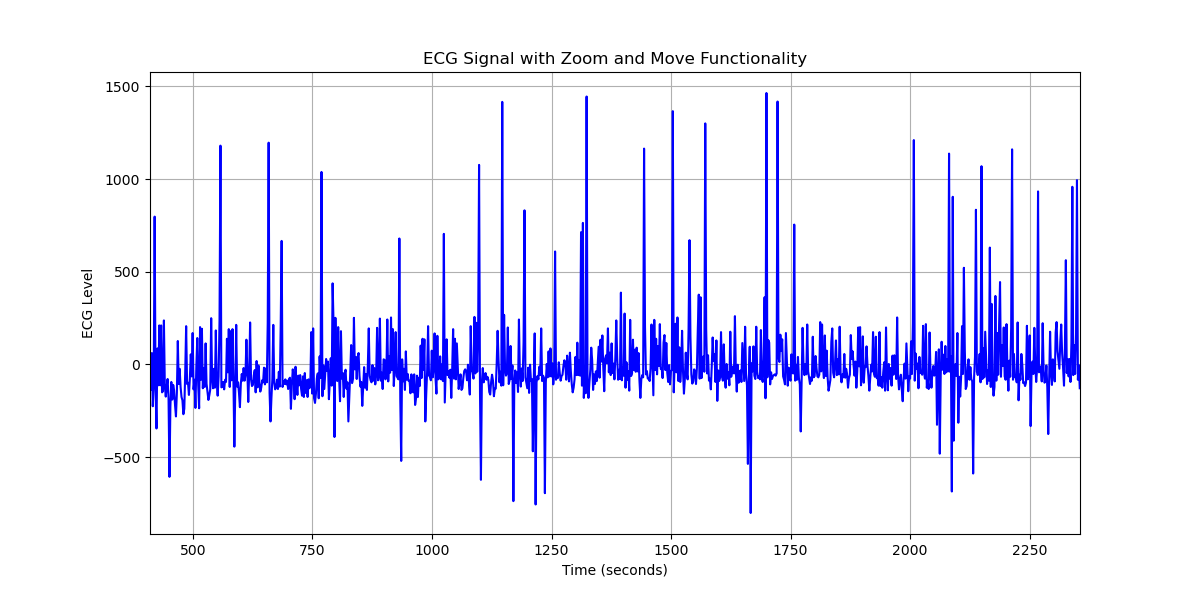

In [21]:
%matplotlib widget
spectHRplot(tDataSet)


In [14]:
tDataSet.ecg.RTopTimes


53455      411.122868
53536      411.743862
53615      412.347456
53693      412.950144
53769      413.539038
             ...     
305879    2352.504725
305921    2352.825197
306002    2353.453987
306086    2354.095502
306174    2354.773682
Length: 2589, dtype: float64